In [114]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import numpy as np
import joblib

## Cargue de datos

In [35]:
train = pd.read_csv("s3://german-credit-255423/datos/train/train.csv")
test = pd.read_csv("s3://german-credit-255423/datos/test/test.csv")

## Creación del pipeline

In [36]:
numeric_pipeline = Pipeline(
    [
        ('Imputación con la media',   SimpleImputer(strategy='mean')),
        ('Escalado minmax', MinMaxScaler())
        
    ]
)

In [37]:
categorical_pipeline = Pipeline(
        [
            ('imputación moda', SimpleImputer(strategy='most_frequent')),
            ('onehot encoder', OneHotEncoder(sparse=False))
        ]

)

In [38]:
column_transformer = ColumnTransformer(
            [
                ('numeric pipeline', numeric_pipeline, [0, 1, 2]),
                ('categorical pipeline', categorical_pipeline, [3, 4, 5])
            ]
)

In [39]:
features = ["Age", "Credit amount", "Duration", "Sex", "Purpose", "Housing"]

### Selección de características

In [40]:
train = train.dropna()

In [41]:
X_train = train.drop(["Risk", "Unnamed: 0"], axis=1)

In [82]:
y_train = train["Risk"]

In [83]:
y_train = (y_train=='good').astype("int")

In [43]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 699
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               361 non-null    int64 
 1   Sex               361 non-null    object
 2   Job               361 non-null    int64 
 3   Housing           361 non-null    object
 4   Saving accounts   361 non-null    object
 5   Checking account  361 non-null    object
 6   Credit amount     361 non-null    int64 
 7   Duration          361 non-null    int64 
 8   Purpose           361 non-null    object
dtypes: int64(4), object(5)
memory usage: 28.2+ KB


### Importancia de características usando un Árbol de Decisión

In [44]:
X_train = pd.get_dummies(X_train)

In [45]:
model = DecisionTreeClassifier()

In [46]:
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [47]:
model.feature_importances_

array([0.12443203, 0.04064761, 0.30135959, 0.19628039, 0.0182134 ,
       0.01025807, 0.02620219, 0.        , 0.03521021, 0.0149864 ,
       0.03057997, 0.01864187, 0.01925574, 0.02879681, 0.02060631,
       0.00599456, 0.        , 0.05994562, 0.        , 0.00760165,
       0.02155634, 0.01115465, 0.00827658, 0.        ])

In [50]:
X_train.columns

Index(['Age', 'Job', 'Credit amount', 'Duration', 'Sex_female', 'Sex_male',
       'Housing_free', 'Housing_own', 'Housing_rent', 'Saving accounts_little',
       'Saving accounts_moderate', 'Saving accounts_quite rich',
       'Saving accounts_rich', 'Checking account_little',
       'Checking account_moderate', 'Checking account_rich',
       'Purpose_business', 'Purpose_car', 'Purpose_domestic appliances',
       'Purpose_education', 'Purpose_furniture/equipment', 'Purpose_radio/TV',
       'Purpose_repairs', 'Purpose_vacation/others'],
      dtype='object')

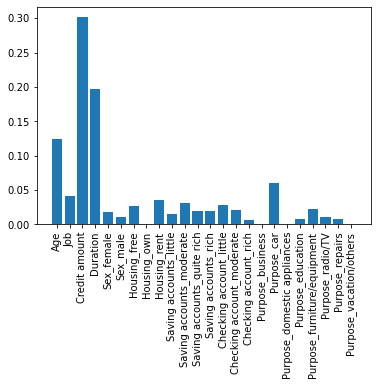

In [55]:
plt.bar(x=X_train.columns, 
        height=model.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

In [66]:
ordered_columns = X_train.columns[np.argsort(model.feature_importances_)[::-1]]

In [67]:
ordered_importance = np.sort(model.feature_importances_)[::-1]

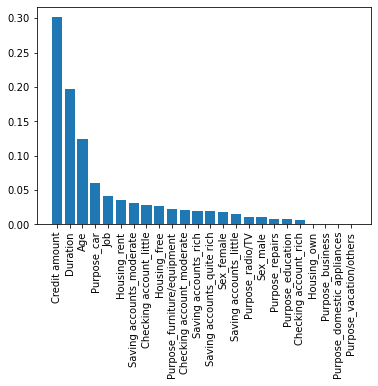

In [69]:
plt.bar(x=ordered_columns, 
        height=ordered_importance)
plt.xticks(rotation = 90)
plt.show()

### Regresión Logística

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [72]:
X_train_scaled = MinMaxScaler().fit_transform(X_train)

In [74]:
model = LogisticRegression()


In [77]:
model.fit(X_train_scaled, y_train)

LogisticRegression()

In [78]:
model.coef_

array([[ 0.47424606,  0.46040332, -0.92624159, -2.03116232, -0.19687034,
         0.19696162,  0.06881668,  0.14613817, -0.21486357, -0.46689979,
        -0.41031105,  0.29891103,  0.57839108, -0.38283643, -0.16388134,
         0.54680905,  0.28173634,  0.11494351, -0.14531633, -0.93147024,
         0.17853055,  0.27162217,  0.07962265,  0.15042262]])

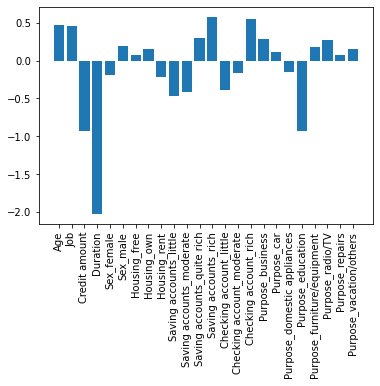

In [80]:
plt.bar(x=X_train.columns, 
        height=model.coef_[0])
plt.xticks(rotation = 90)
plt.show()

### Evaluación de modelos

In [102]:
train = pd.read_csv("s3://german-credit-255423/datos/train/train.csv")
X_train = train.drop(["Risk", "Unnamed: 0"], axis=1)
y_train = train["Risk"]
y_train = (y_train=='good').astype("int")

In [103]:
final_pipeline = Pipeline(
            [
                ("preprocesamiento", column_transformer),
                ("modelo", DecisionTreeClassifier(max_depth=3))
            ]
)

In [104]:
X_train = train[features]

In [105]:
results = cross_validate(final_pipeline, X_train, y_train, 
                         cv=10, return_train_score=True,
                        scoring=["accuracy", "f1"])

In [106]:
print("train: ",results["train_accuracy"].mean(), "+-",results["train_accuracy"].std())
print("val: ",results["test_accuracy"].mean(), "+-",results["test_accuracy"].std())

train:  0.7474603174603175 +- 0.0027902215605153783
val:  0.7214285714285713 +- 0.01317077779613268


In [108]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

### Ajuste de hiperparámetros RandomForest

#Probar, 50 árboles, 100 árboles, 200 árboles, alturas: 2, 3, 5, 10

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [111]:
grid = {"n_estimators": [50, 100, 200], "max_depth":  [2, 3, 5, 10]}

In [112]:
X_transformed = column_transformer.fit_transform(X_train)

In [115]:
grid_search = GridSearchCV(
RandomForestClassifier(),    
param_grid=grid,
cv=10,
scoring="accuracy"
)

In [116]:
grid_search.fit(X_transformed, y_train)

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 3, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [117]:
grid_search.best_params_

{'max_depth': 5, 'n_estimators': 100}

In [118]:
grid_search.cv_results_

{'mean_fit_time': array([0.13302641, 0.15969245, 0.31499774, 0.08202522, 0.16182878,
        0.32407691, 0.08682663, 0.16941326, 0.33765357, 0.09457829,
        0.18602183, 0.37179577]),
 'std_fit_time': array([0.06566443, 0.00248799, 0.00366656, 0.00130412, 0.00225257,
        0.00464986, 0.00303037, 0.00237192, 0.00624913, 0.00182313,
        0.00262245, 0.00646449]),
 'mean_score_time': array([0.0070142 , 0.00944648, 0.01755517, 0.00497401, 0.00914433,
        0.0176295 , 0.00522072, 0.00928559, 0.01786847, 0.00533595,
        0.00979471, 0.01888089]),
 'std_score_time': array([3.08392786e-03, 7.96360442e-04, 7.11995004e-04, 5.46542807e-05,
        4.25787081e-05, 1.78147257e-04, 5.45510859e-04, 6.83045054e-05,
        5.24777867e-04, 7.40738708e-05, 4.68095279e-05, 2.10158338e-04]),
 'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 5, 5, 5, 10, 10, 10],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False]

### Entrenamiento final

In [120]:
final_pipeline = Pipeline(
            [
                ("preprocesamiento", column_transformer),
                ("modelo", RandomForestClassifier(max_depth=5, 
                                                  n_estimators=100))
            ]
)

In [ ]:
final_pipeline.fit(X_trainm,)